Source: https://stats.stackexchange.com/questions/72774/numerical-example-to-understand-expectation-maximization Suppose we have two groups - red and blue. Specifically, each group contains a value drawn from a normal distribution with the following parameters:

In [20]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from collections import namedtuple, Counter

np.random.seed(110) # for reproducible random results

## More automatic example

## Helpers EM

In [3]:
def estimate_initial_params(data, n_clusters):
    means=np.random.choice(data, size=n_clusters, replace=False)
    stds=np.array([0.1 for i in range(n_clusters)])
    return means, stds

In [4]:
def calculate_likelihood(data, class_means, class_stds):
    likelihoods=np.array([stats.norm(mean, std).pdf(data) for mean, std in zip(class_means, class_stds)])
    likelihoods_sum=likelihoods.sum(axis=0)
    classes_weights=likelihoods/likelihoods_sum
    
    return classes_weights.T
    

In [5]:
def estimate_mean(data, weight):
    return np.sum(data * weight) / np.sum(weight)

def estimate_std(data, weight, mean):
    variance = np.sum(weight * (data - mean)**2) / np.sum(weight)
    return np.sqrt(variance)

In [6]:
def estimate_means_stds(data, weights):
    means=[estimate_mean(data, weight) for weight in weights]
    stds=[estimate_std(data, weight, mean) for weight, mean in zip(weights, means)]
    return means, stds

In [7]:
def em(data, n_clusters, n_iters=50):
    means, stds = estimate_initial_params(data, n_clusters)
    
    for i in range(n_iters):
        class_weights = calculate_likelihood(data, means, stds) 
        means, stds = estimate_means_stds(df.data, class_weights.T)
        
    return means, stds, class_weights

#### run example

In [11]:
df=pd.read_csv('clusters.csv')
df.columns=['id', 'data']

In [12]:
means, stds, class_weigths = em(df.data, 3, n_iters=20)

In [13]:
def plot_data_results(df_data, means, stds):
    ax=df_data.hist(bins=20, density=True)
    x = np.arange(df_data.min(),df_data.max(), 0.001)
    
    for i in range(len(means)):
        plt.plot(x, stats.norm.pdf(x, means[i], stds[i]), color='red')


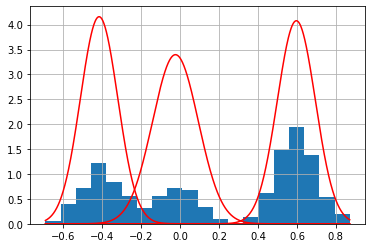

In [14]:
plot_data_results(df.data, means, stds)

In [15]:
class_id=class_weigths.argmax(axis=1)

In [16]:
def plot_clusters(data, class_weights):
    class_id=class_weigths.argmax(axis=1)
    gby = pd.DataFrame({
            'data': data, 
            'assignment': class_id}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist() 
                 for cid in gby.groups.keys()]
    plt.hist(hist_data, 
             bins=20,
             histtype='stepfilled', alpha=.2 )

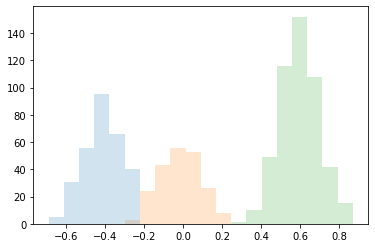

In [18]:
#nicely separated
plot_clusters(df.data, class_weigths)

## Gibbs sampling

In [55]:
state['suffstats']

[SuffStat(theta=-0.006666114310027213, N=204),
 SuffStat(theta=0.5968496069309959, N=493),
 SuffStat(theta=-0.40827312621996686, N=302)]

### helpers

In [38]:
SuffStat = namedtuple('SuffStat', 'theta N')

def update_suffstats(state):
    for cluster_id, N in Counter(state['assignment']).items():
        points_in_cluster = [x 
            for x, cid in zip(state['data_'], state['assignment'])
            if cid == cluster_id
        ]
        mean = np.array(points_in_cluster).mean()
        
        state['suffstats'][cluster_id] = SuffStat(mean, N)

def initial_state(data, num_clusters):
    num_clusters = num_clusters
    alpha = 1.0
    cluster_ids = range(num_clusters)

    state = {
        'cluster_ids_': cluster_ids,
        'data_': data,
        'num_clusters_': num_clusters,
        'cluster_variance_': .01,
        'alpha_': alpha,
        'hyperparameters_': {
            "mean": 0,
            "variance": 1,
        },
        'suffstats': [None, None, None],
        'assignment': [np.random.choice(cluster_ids) for _ in data],
        'pi': [alpha / num_clusters for _ in cluster_ids],
        'cluster_means': np.random.choice(data, size=num_clusters, replace=False)
    }
    update_suffstats(state)
    return state


In [69]:
cluster_ids = range(3)
assign= [np.random.choice(cluster_ids) for _ in df.data]
    



In [72]:
def update_suffstats2(data, assignments):
    assignments=np.array(assignments)
    suffstat=[]
    for cluster_idx in list(set(assignments)):
        cluster_data_idx=assignments[assignments==cluster_idx]
        mean=data[cluster_data_idx].mean()
        N=len(cluster_data_idx)
        
        suffstat.append(SuffStat(mean, N))
    return suffstat

In [82]:
def log_assignment_score(data_point, cluster_mean, cluster_variance, pi_cluster):
    """log p(z_i=k \,|\, \cdot) 
    
    We compute these scores in log space for numerical stability.
    """
    x = data_point
    theta = cluster_mean
    var = cluster_variance
    log_pi = np.log(pi_cluster)
    return log_pi + stats.norm.logpdf(x, theta, var)


def assigment_probs(data_point, cluster_means, cluster_variance, pi):
    """p(z_i=cid \,|\, \cdot) for cid in cluster_ids
    """
    scores = [log_assignment_score(data_point, cluster_means[cid], cluster_variance, pi[cid]) for cid in cluster_ids]

    scores = np.exp(np.array(scores))
    return scores / scores.sum()


def sample_assignment(data_point, cluster_ids, cluster_means, cluster_variance, pi):
    """Sample cluster assignment for data_id given current state
    
    cf Step 1 of Algorithm 2.1 in Sudderth 2006 http://cs.brown.edu/~sudderth/papers/sudderthPhD.pdf
    """
    try:
        p = assigment_probs(data_point, cluster_means, cluster_variance, pi)
        return np.random.choice(cluster_ids, p=p)
    except:
        #hack, sometimes all p-s are zero, then return cluster 0
        return 0


def update_assignment(data, cluster_ids, cluster_means, cluster_variance, pi, assignments):
    """Update cluster assignment for each data point given current state 
    
    cf Step 1 of Algorithm 2.1 in Sudderth 2006
    """
    for data_id, data_point in enumerate(data):
        assignments[data_id] = sample_assignment(data_point, cluster_ids, cluster_means, cluster_variance, pi)
#     update_suffstats(state)
    suffstat = update_suffstats2(data, assignments)
    return assignments, suffstat

In [76]:
def sample_mixture_weights(alpha, num_clusters, cluster_ids, suffstats):
    """Sample new mixture weights from current state according to 
    a Dirichlet distribution 
    
    cf Step 2 of Algorithm 2.1 in Sudderth 2006
    """
    ss = suffstats
    alpha = [ss[cid].N + alpha / num_clusters
             for cid in cluster_ids]
    return stats.dirichlet(alpha).rvs(size=1).flatten()

def update_mixture_weights(alpha, num_clusters, cluster_ids, suffstats, pi):
    """Update state with new mixture weights from current state
    sampled according to a Dirichlet distribution 
    
    cf Step 2 of Algorithm 2.1 in Sudderth 2006
    """
    pi = sample_mixture_weights(alpha, num_clusters, cluster_ids, suffstats)
    return pi

In [77]:
def sample_cluster_mean(cluster_id, cluster_var, hp_mean, hp_var, suffstats_cluster):
#     cluster_var = state['cluster_variance_']
#     hp_mean = state['hyperparameters_']['mean']
#     hp_var = state['hyperparameters_']['variance']
    ss = suffstats_cluster
    
    numerator = hp_mean / hp_var + ss.theta * ss.N / cluster_var
    denominator = (1.0 / hp_var + ss.N / cluster_var)
    posterior_mu = numerator / denominator
    posterior_var = 1.0 / denominator
    
    return stats.norm(posterior_mu, np.sqrt(posterior_var)).rvs()


def update_cluster_means(cluster_ids, cluster_variance, hp_mean, hp_var, suffstats):
    cluster_means = [sample_cluster_mean(cid, cluster_variance, hp_mean, hp_var, suffstats[cid])
                              for cid in cluster_ids]
    return cluster_means

## Run experiment

In [47]:
def gibbs(data, num_clusters, num_steps=5, cluster_variance=0.1, alpha=1.0, hp_mean=0, hp_var=1):
    
    #init variables
    cluster_ids = range(num_clusters)
    assignments = [np.random.choice(cluster_ids) for _ in data]
    pi = [alpha / num_clusters for _ in cluster_ids]
    cluster_means = np.random.choice(data, size=num_clusters, replace=False)
    suffstats = update_suffstats2(data, assignments)
    
    for i in range(num_steps):
        assignments, suffstat = update_assignment(data, cluster_ids, cluster_means, cluster_variance, pi, assignments)
        pi = update_mixture_weights(alpha, num_clusters, cluster_ids, suffstats, pi)
        cluster_means = update_cluster_means(cluster_ids, cluster_variance, hp_mean, hp_var, suffstats)
    return assignments, cluster_means, pi

In [99]:
assignments, cluster_means, pi=gibbs(df.data, 3, num_steps=20)

(array([[  2.,   9.,  25.,  45.,  35.,  28.,  14.,  33.,  45.,  43.,  22.,
           1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  3.,  22.,  31.,  50.,  31.,  15.,  10.,  10.,  11.,  10.,   4.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           7.,   1.,  10.,  49., 116., 152., 108.,  42.,  15.]]),
 array([-0.69068298, -0.61257196, -0.53446093, -0.45634991, -0.37823889,
        -0.30012787, -0.22201684, -0.14390582, -0.0657948 ,  0.01231622,
         0.09042724,  0.16853827,  0.24664929,  0.32476031,  0.40287133,
         0.48098236,  0.55909338,  0.6372044 ,  0.71531542,  0.79342644,
         0.87153747]),
 <a list of 3 list[Polygon] objects>)

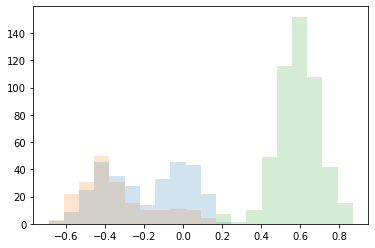

In [100]:
gby = pd.DataFrame({
            'data': df.data, 
            'assignment': assignments}
        ).groupby(by='assignment')['data']
hist_data = [gby.get_group(cid).tolist() 
             for cid in gby.groups.keys()]
plt.hist(hist_data, 
         bins=20,
         histtype='stepfilled', alpha=.2 )